# Krypton Lifetime

## Produce lifetime map 

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Aug 27 15:36:17 2018


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = ' '
map_file_name     = 'kr_maps_6206.h5'
map_file_name_ts  = 'kr_maps_ts_6206.h5'
emap_file_name    = 'kr_emap_6206.h5'



krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [9]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts

In [10]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [11]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [12]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [13]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [14]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName
from krcal.core          import fit_functions_ic as fitf

In [55]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_alpha_map
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps

In [16]:
import krcal.dev.corrections       as corrections 


In [30]:
from numpy import pi, sqrt

In [18]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [19]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [20]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [21]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_10000_19999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_20000_29999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6206.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_ts_6206.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_6206.h5')

In [22]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [23]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [24]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [25]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [230]:
RMAX      = 180
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-RMAX,  RMAX)
z_range   = (50,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [28]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

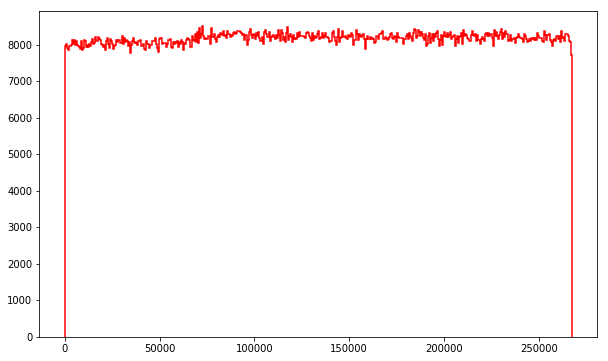

In [29]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

## Divide chamber in sector of R and Phi

In [231]:
#R, PHI = rphi_sector_alpha_map(rmin  =  20,
#                               rmax  = 180,
#                               alpha =  0.5,
#                               sphi  = 5)

In [192]:
R, PHI = rphi_sector_map(nSectors=20, rmax=180, sphi=10)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [193]:
W = define_rphi_sectors(R, PHI, verbose=False)
nSectors = len(R.keys())
print(f'nSectors = {nSectors}')

nSectors = 20


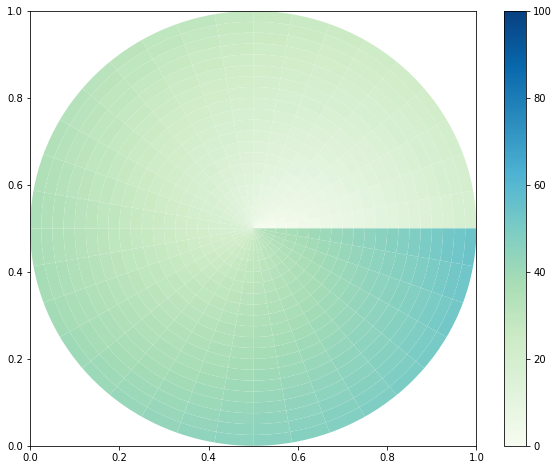

In [194]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(nSectors))

In [195]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W, verbose = True)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 calling selection_mask
 sector = 0
 sector = 1
 sector = 2
 sector = 3
 sector = 4
 sector = 5
 sector = 6
 sector = 7
 sector = 8
 sector = 9
 sector = 10
 sector = 11
 sector = 12
 sector = 13
 sector = 14
 sector = 15
 sector = 16
 sector = 17
 sector = 18
 sector = 19
 selection_mask computed, filling RGES
 defining kr_event for sector 0
 defining kr_event for sector 1
 defining kr_event for sector 2
 defining kr_event for sector 3
 defining kr_event for sector 4
 defining kr_event for sector 5
 defining kr_event for sector 6
 defining kr_event for sector 7
 defining kr_event for sector 8
 defining kr_event for sector 9
 defining kr_event for sector 10
 defining kr_event for sector 11
 defining kr_event for sector 12
 defining kr_event for sector 13
 defining kr_event for sector 14
 defining kr_event for sector 15
 defining kr_event for sector 16
 defining kr_event for sector 17
 defining kr_event for sector 18
 defining kr_event for sector 19
 RGES computed
 KRES: t = 59.14556694

### Time 

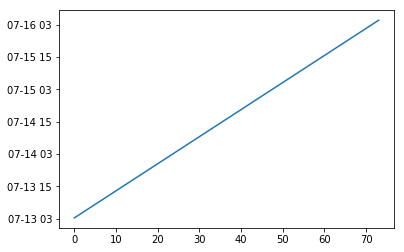

In [69]:
plt.plot(krTimes.timeStamps)

### Event distribution

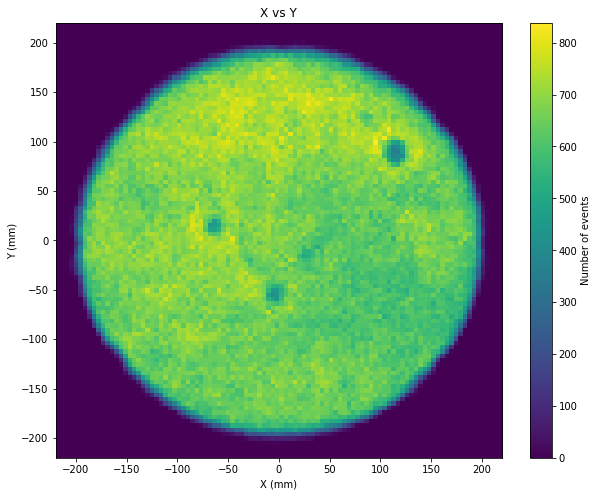

In [70]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Events per sector

number of events in sector = 8944.0


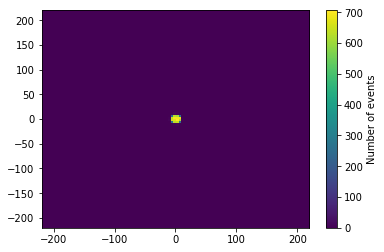

In [196]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=0)

number of events in sector = 8944.0
number of events in sector = 26498.0
number of events in sector = 43939.0
number of events in sector = 59225.0
number of events in sector = 76340.0
number of events in sector = 95856.0
number of events in sector = 111776.0
number of events in sector = 129361.0
number of events in sector = 148483.0
number of events in sector = 165518.0
number of events in sector = 182650.0
number of events in sector = 201233.0
number of events in sector = 220028.0
number of events in sector = 239011.0
number of events in sector = 257491.0
number of events in sector = 274492.0
number of events in sector = 291495.0
number of events in sector = 308084.0
number of events in sector = 324357.0
number of events in sector = 335968.0


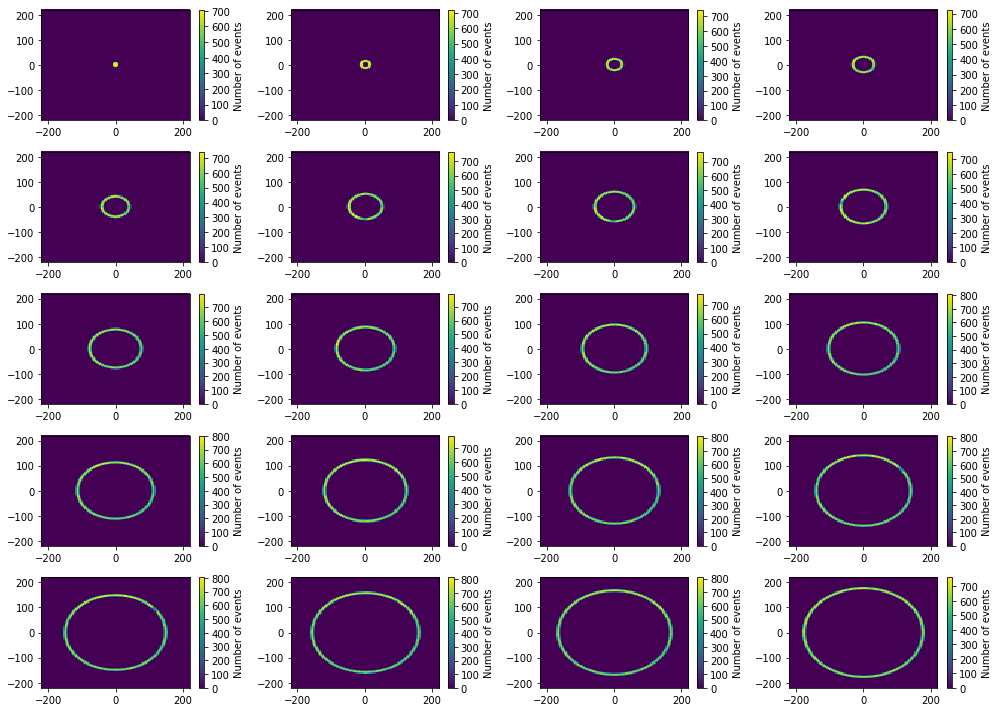

In [197]:
plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, nx = 5, ny =4,figsize=(14,10))

## Fits in radial sectors

### Lifetime is fitted each XT seconds in the radial sectors (0 to 9) defined.

In [198]:
DT[-1] /65000

4.114518584614534

In [199]:
XT = 65000

In [200]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
                    

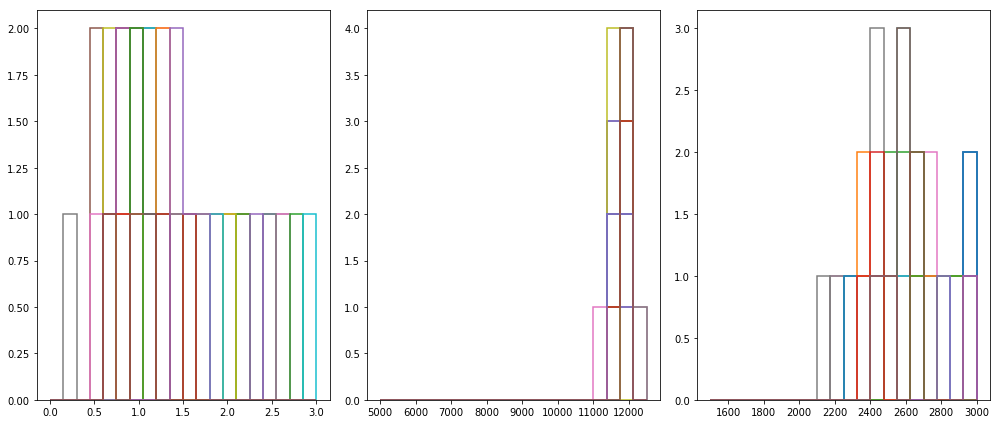

In [201]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1500, 3000))
#print_fit_sectors_pars(fpts)

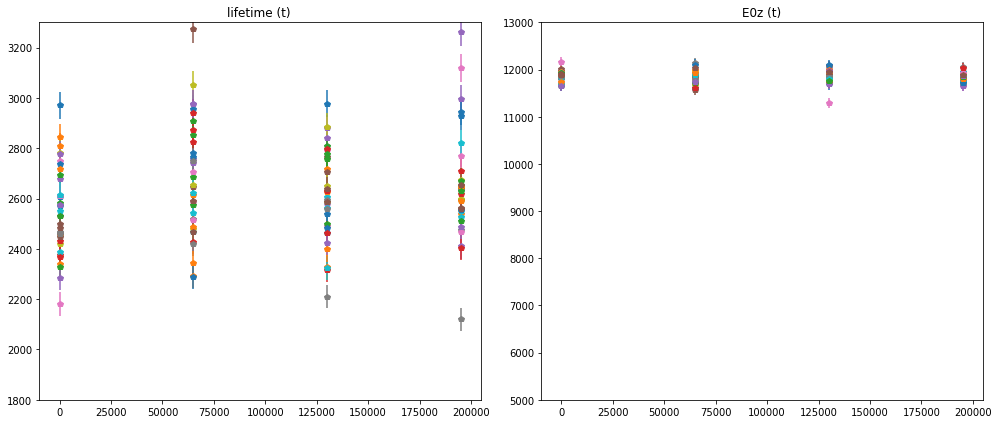

In [202]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3300))

In [203]:
fps = fit_fcs_in_sectors(10, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
 

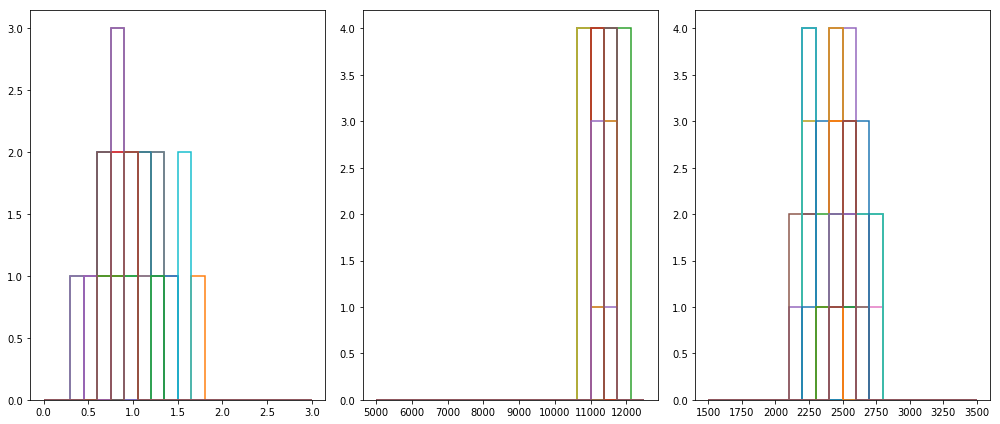

In [204]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1500, 3500))
#print_fit_sectors_pars(fpts )

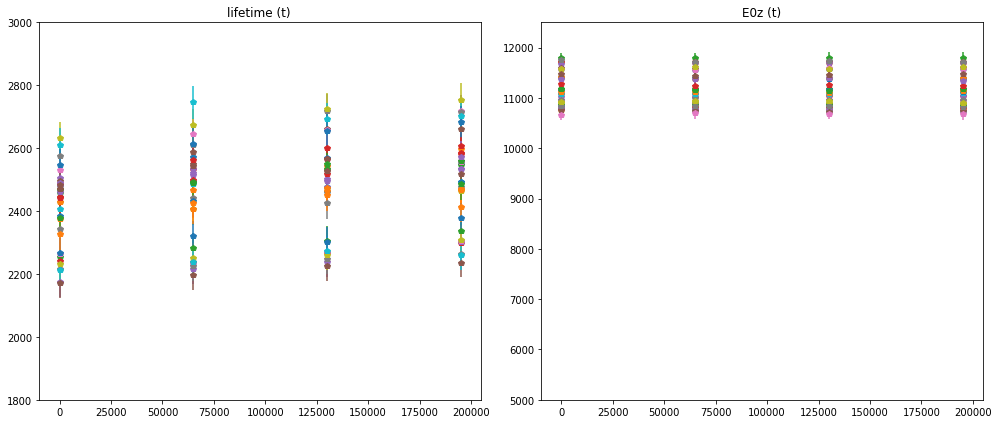

In [205]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [207]:
fps = fit_fcs_in_sectors(19, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)



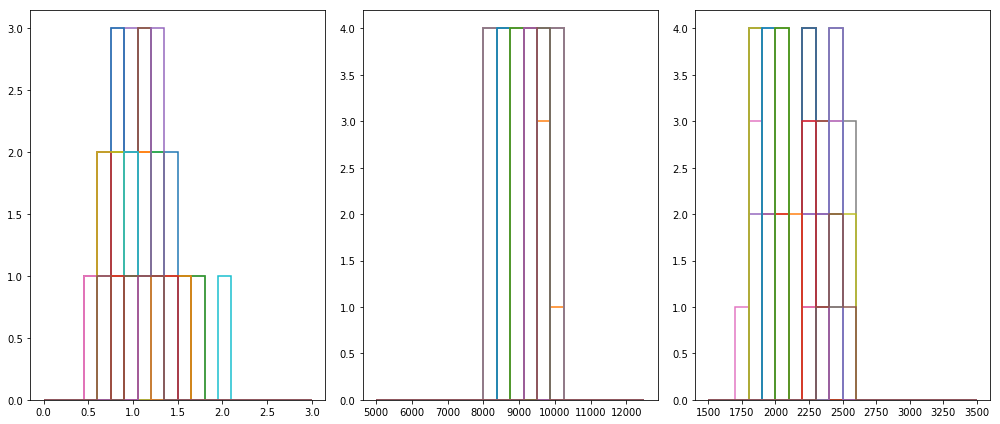

In [208]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1500, 3500))
#print_fit_sectors_pars(fpts)

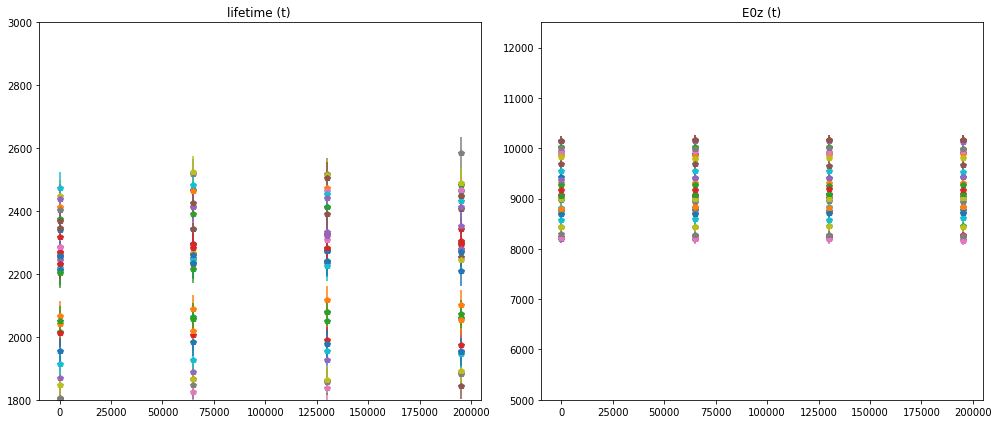

In [209]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

### Fits in sectors:
1. chi2 of fits is good.
2. E0 decreases in each sector and varies significantly with phi.
3. At large Radii LT spreads enormously, the effect is much larger than time variations, suggesting that an average map (in time) should work just fine. 

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```
Thus, for each radial sector (0, 1, 2...) the function returns a list of objects, one object per phi sector (or wedge). Each object contains 6 time series; ts is time (time difference wrt to the start of the run); e0, lt... are fitted parameters to time slices.

In [210]:
fmap = fit_map(XT, DT, KRES, 
               krNbins.Z, krNbins.S2e,
               range_z     = (50,550),
               range_e     = (5000, 13000),
               range_chi2  = (0,3),
               range_lt    = (1700, 3300),
               energy      = 'S2e', 
               fit         = FitType.profile,
               verbose     = True)

Fitting sector 0
 number of wedges in sector 36
Fitting sector 1
 number of wedges in sector 36
Fitting sector 2
 number of wedges in sector 36
Fitting sector 3
 number of wedges in sector 36
Fitting sector 4
 number of wedges in sector 36
Fitting sector 5
 number of wedges in sector 36
Fitting sector 6
 number of wedges in sector 36
Fitting sector 7
 number of wedges in sector 36
Fitting sector 8
 number of wedges in sector 36
Fitting sector 9
 number of wedges in sector 36
Fitting sector 10
 number of wedges in sector 36
Fitting sector 11
 number of wedges in sector 36
Fitting sector 12
 number of wedges in sector 36
Fitting sector 13
 number of wedges in sector 36
Fitting sector 14
 number of wedges in sector 36
Fitting sector 15
 number of wedges in sector 36
Fitting sector 16
 number of wedges in sector 36
Fitting sector 17
 number of wedges in sector 36
Fitting sector 18
 number of wedges in sector 36
Fitting sector 19
 number of wedges in sector 36


In [211]:
ts = fmap[0][0].ts

In [212]:
ts

array([     0,  65000, 130000, 195000])

In [133]:
DT

array([0.00000000e+00, 2.16000080e-01, 2.30000019e-01, ...,
       2.67443503e+05, 2.67443696e+05, 2.67443708e+05])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [213]:
tsm = tsmap_from_fmap(fmap, verbose  = False)

<ErrorbarContainer object of 3 artists>

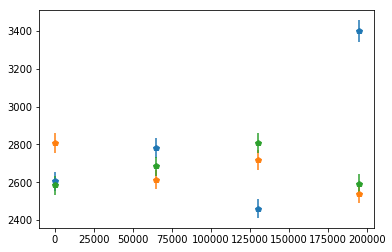

In [214]:
plt.errorbar(ts, tsm.lt[0][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[0][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[0][2], np.sqrt(tsm.lt[0][2]), fmt="p")

<ErrorbarContainer object of 3 artists>

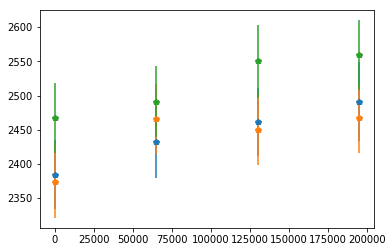

In [216]:
plt.errorbar(ts, tsm.lt[10][10], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[10][11], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[10][12], np.sqrt(tsm.lt[0][2]), fmt="p")

<ErrorbarContainer object of 3 artists>

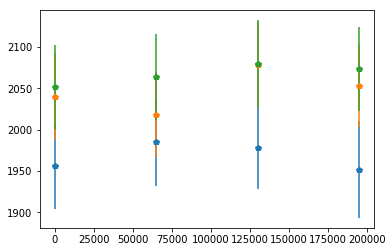

In [217]:
plt.errorbar(ts, tsm.lt[19][30], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[19][31], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[19][32], np.sqrt(tsm.lt[0][2]), fmt="p")

#### Obtain ampa from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : Dict[int, List[float]]
    e0    : Dict[int, List[float]]
    lt    : Dict[int, List[float]]
    e0u   : Dict[int, List[float]]
    ltu   : Dict[int, List[float]]
```
In this ASectorMap each wege contains a single number, and thus ASectorMap is really a 
collection of 5 maps. 

#### The map that averages the time series is obtained by setting ts = -1 

In [218]:
am = amap_from_tsmap(tsm, 
                     ts = -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1500, 3000))

In [219]:
asm = relative_errors(am)

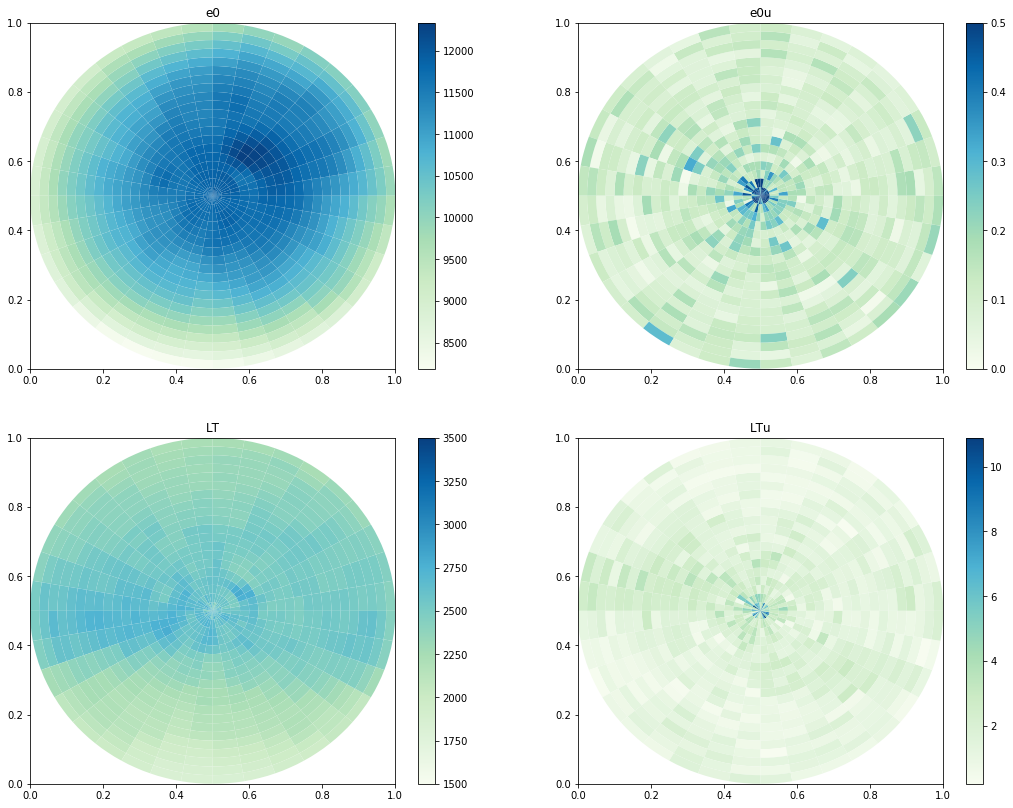

In [220]:
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3500),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

#### The maps can be saved to file

In [221]:
write_maps(asm, filename=fn.map_file_name)

#### And retrieved from file

In [222]:
me0df, me0udf, mltdf, mltudf = read_maps(filename=fn.map_file_name)

#### To produce a map for a given point in the same series one uses ts = 0, 1... len(ts)

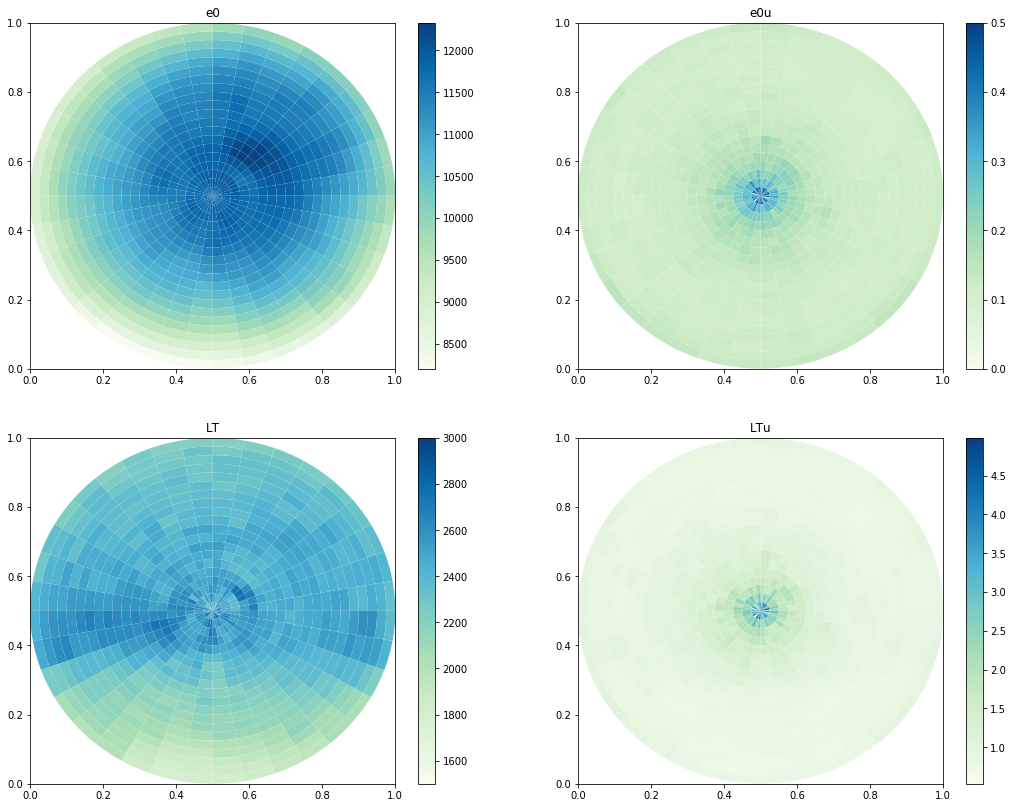

In [223]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

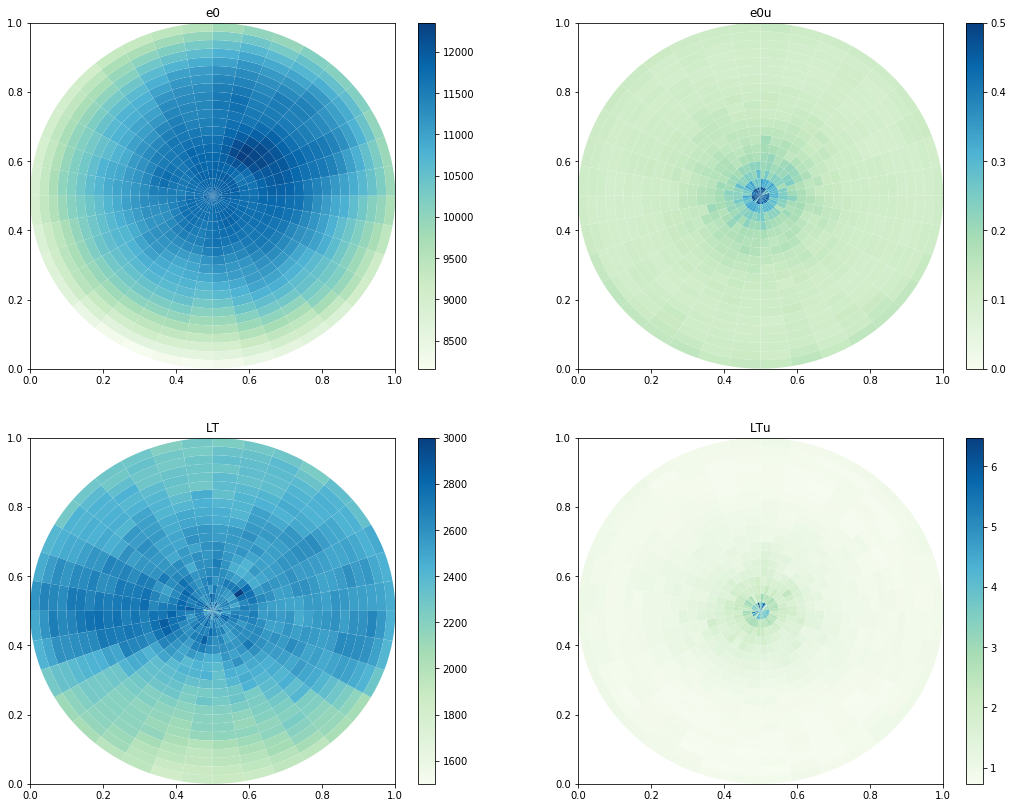

In [224]:
am = amap_from_tsmap(tsm, 
                     ts = len(ts) -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

#### Full map series:

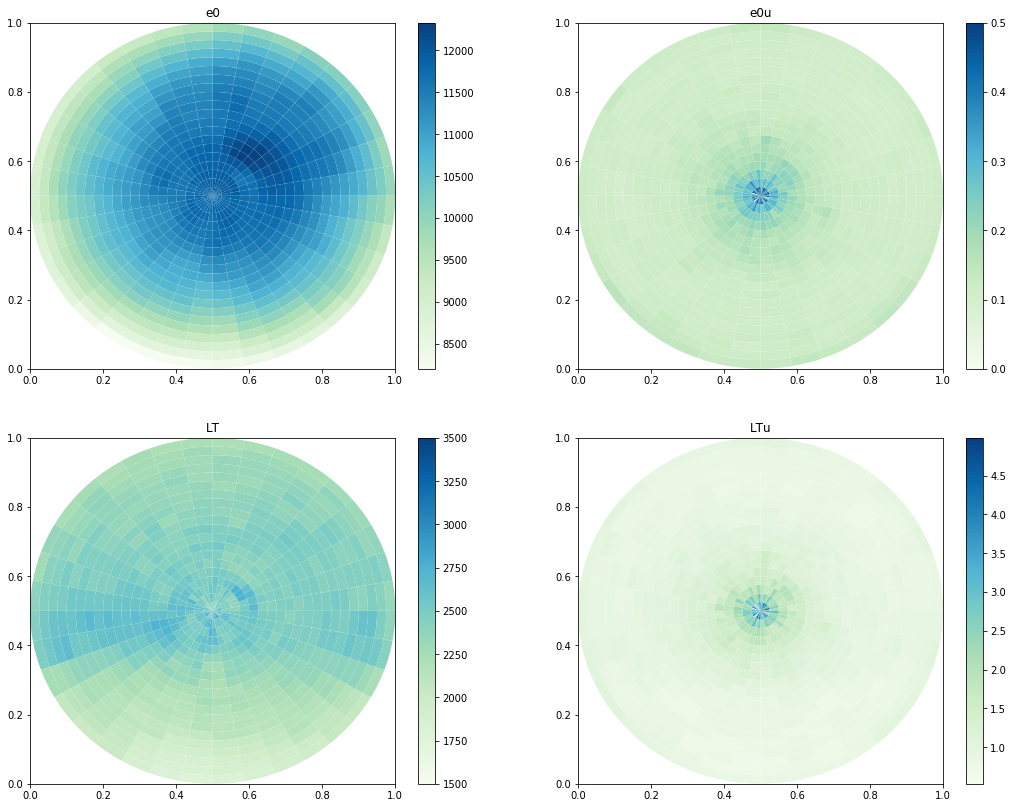

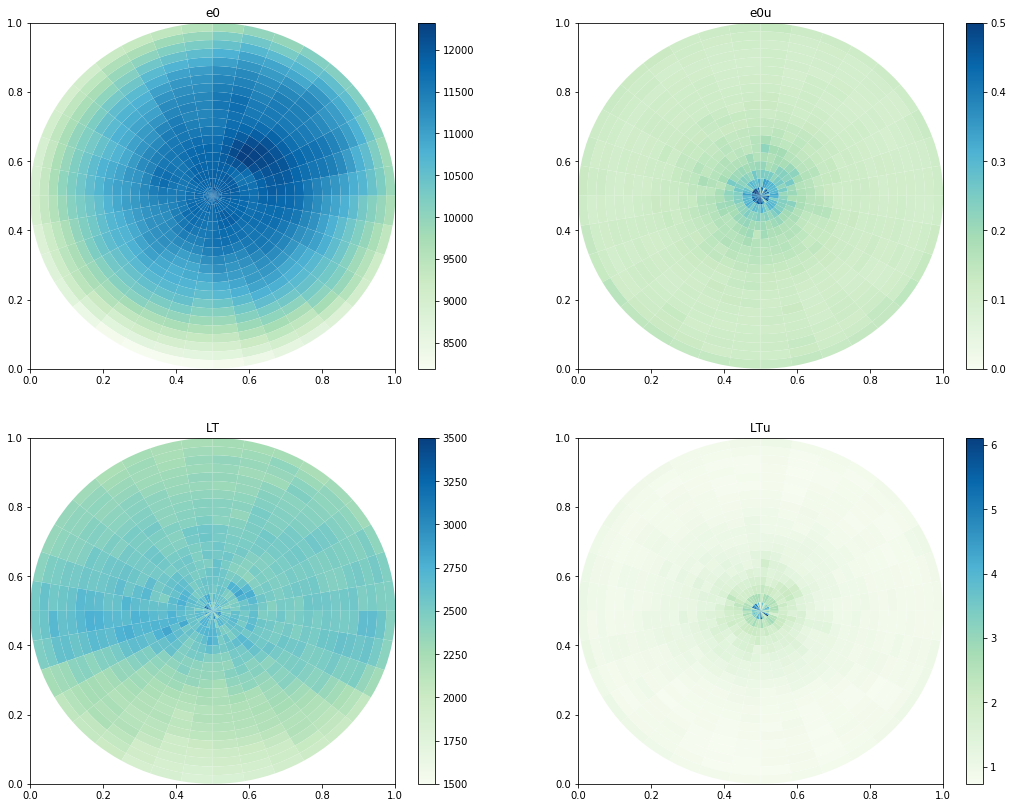

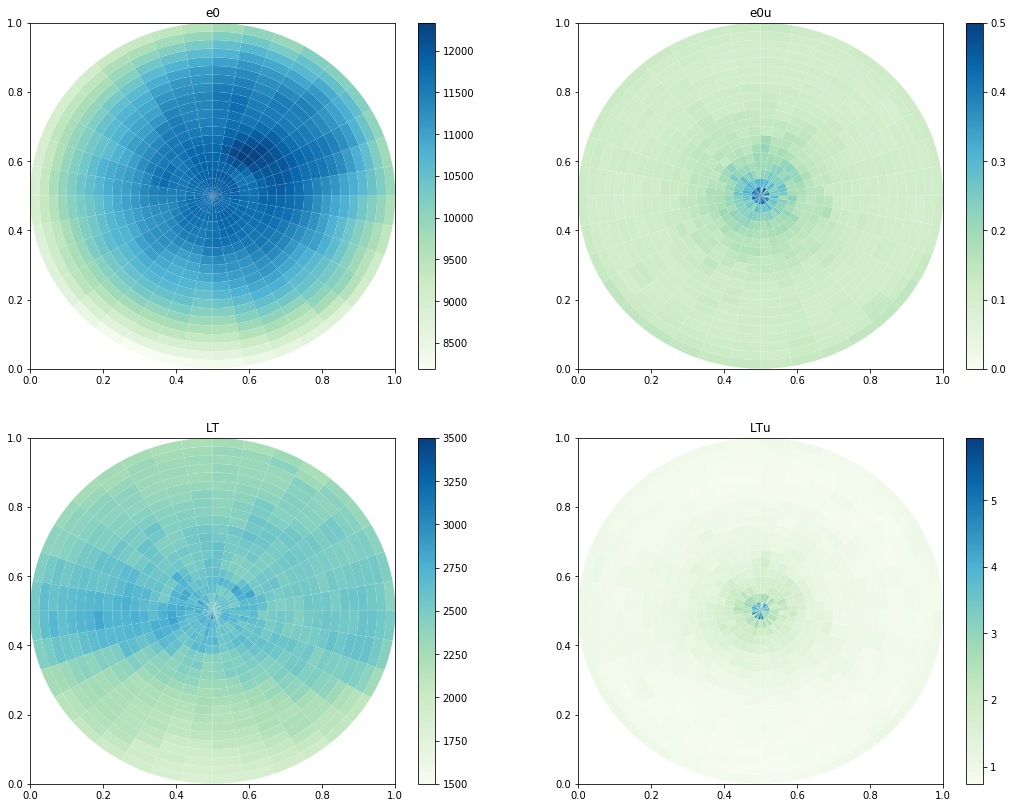

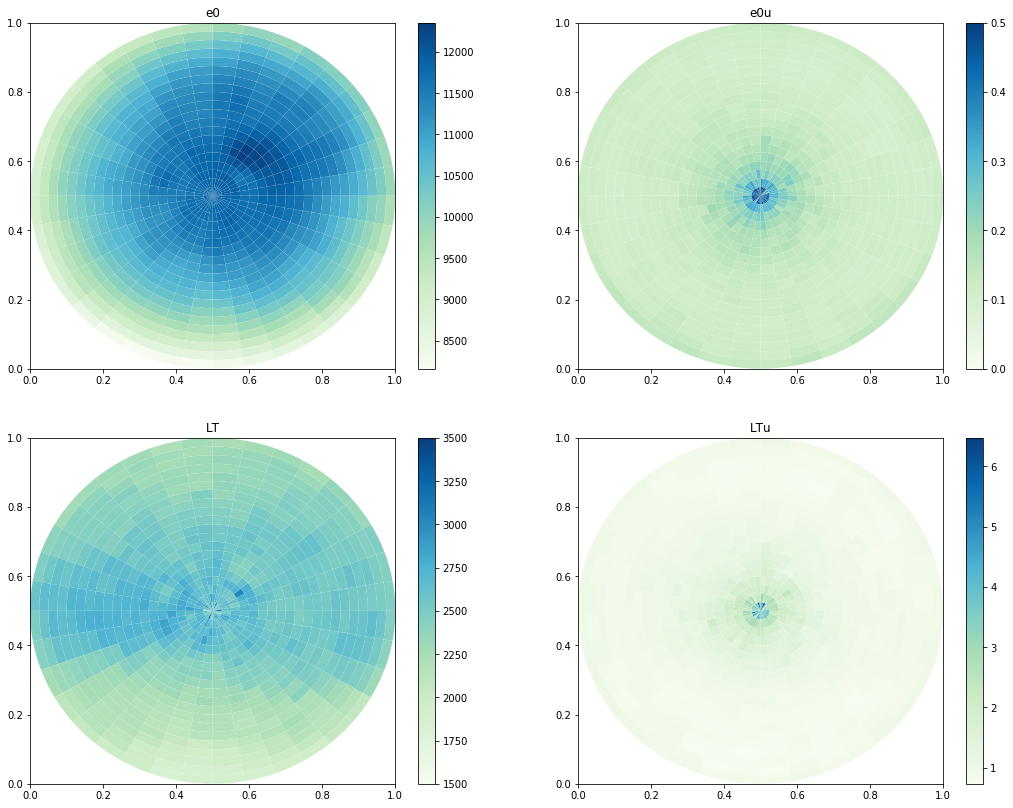

In [225]:
aMaps = []
draw = True
for i, _ in enumerate(ts):
    am = amap_from_tsmap(tsm, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,3),
                         range_lt    = (1500, 3700))
    asm = relative_errors(am)
    aMaps.append(am)
    if draw:
        draw_maps(W, asm,  
                  e0lims  = None,
                  ltlims  = (1500, 3500),
                  eulims  = (0, 0.5),
                  lulims  = None,
                  cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                  alpha   = 1.0,  
                  figsize=(18,14))

#### To write the complete time-series of maps
```
write_maps_ts(aMaps : Iterable[ASectorMap], ts: np.array, filename : str)
```

In [226]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)